In [1]:
# python imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
import astropy as ap
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
from astropy.cosmology import FlatLambdaCDM
import pandas as pd

# lenstronomy imports
# Util
from lenstronomy.Util import util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.param_util as param_util
# Data
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
# ImSim
from lenstronomy.ImSim.image_model import ImageModel
# SimAPI
from lenstronomy.SimulationAPI.sim_api import SimAPI
# LensModel
from lenstronomy.LensModel.lens_model import LensModel 
# LightModel
from lenstronomy.LightModel.light_model import LightModel
# Plots
from lenstronomy.Plots.lens_plot import lens_model_plot
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
# Workflow
from lenstronomy.Workflow.fitting_sequence import FittingSequence


In [28]:
# Open fits files:

# get filenames from desktop
filepath = '/Users/gilliancartwright/Desktop/' # my personal filepath
filename = filepath + 'Right_detectable_Jack_complete (1).fits'

# open fits
hdu_list = fits.open(filename)

# set image data and bin data
image = hdu_list['IMAGE'].data

# show bin data
data = pd.DataFrame(hdu_list[2].data)

# drop unused columns 
# note: this makes a new data frame so you can still access the original data with all columns if needed
data_df = data.drop(columns=['HPIX_16384','HPIX_4096', 'KRON_RADIUS', 'GAP_FLUX_G',
                             'RANK', 'MOF_BDF_FLUX_G', 'MOF_PSF_FLUX_G', 'SOF_BDF_FLUX_G',
                            'SOF_PSF_FLUX_G', 'IMAFLAGS_ISO_G', 'IMAFLAGS_ISO_R', 'IMAFLAGS_ISO_I',
                             'IMAFLAGS_ISO_Z', 'MEM_MATCH_ID', 'ACT', 'BBNA', 'BNA', 'TI', 
                            'RNA', 'RNA2', 'REDM', 'REDM_MISSED', 'SPTPOL', 'PROB', 
                             'FWHM_WMEAN_Z', 'SKYBRITE_WMEAN_Z', 'FLUX_RADIUS_G', 'FLUX_RADIUS_R',
                             'FLUX_RADIUS_I', 'FLUX_RADIUS_Z', 'TILENAME', 'MAG_AUTO_G', 'MAG_APER_4_G',
                             'MAG_APER_8_G', 'SOF_BDF_G_1', 'SOF_BDF_G_2', 'SKYBRITE_WMEAN_G', 
                            'SKYBRITE_WMEAN_R', 'SKYBRITE_WMEAN_I'], axis=1)   
                        
# close
hdu_list.close()

print(data_df.columns)

# show data
data_df.head()



Index(['COADD_OBJECT_ID', 'DNF_ZMEAN_SOF', 'RA', 'DEC', 'NUM_SOURCES',
       'NUM_LENSES', 'EINSTEIN_RADIUS', 'EINSTEIN_RADIUS_ERR', 'FWHM_WMEAN_G',
       'FWHM_WMEAN_R', 'FWHM_WMEAN_I'],
      dtype='object')


,COADD_OBJECT_ID,DNF_ZMEAN_SOF,RA,DEC,NUM_SOURCES,NUM_LENSES,EINSTEIN_RADIUS,EINSTEIN_RADIUS_ERR,FWHM_WMEAN_G,FWHM_WMEAN_R,FWHM_WMEAN_I
0,1238888461,0.462489,31.522325,2.980347,1,1,4.143050,0.490732,1.19076,0.968298,0.871029
1,1015396778,0.569375,353.966419,-51.871635,2,1,3.640202,0.495374,1.20309,1.135740,0.934753
2,1065068829,0.704501,6.294487,-49.774042,1,1,3.209605,0.414951,1.08702,0.947434,0.849465
3,1032611021,0.523857,0.527213,-33.544062,2,2,5.689696,0.828114,1.12866,0.980433,0.830678
4,1090875242,0.580754,10.846679,-62.803256,1,1,3.216561,0.415490,1.05941,0.911823,0.856502


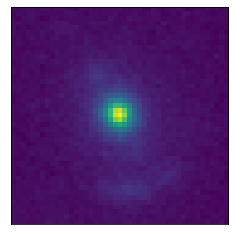

In [80]:
# open files and grab g,r,i data:
def open_fits_image(filename, imgnum): 
    """Input a FITS filename and returns the IMAGE data"""
    hdu_list = fits.open(filename)
    image = hdu_list['IMAGE'].data
    hdu_list.close()

    # separate each color:
    g = image[imgnum,0,:,:]
    r = image[imgnum,1,:,:]
    i = image[imgnum,2,:,:]
    return g,r,i

def plot_image(g,r,i):
      
    # combine into one image:
    image_data = ap.visualization.make_lupton_rgb(i, r, g, stretch = 50, Q = 10)
    
    # set fig and axes
    fig, ax = plt.subplots()
    ax.imshow(image_data, origin = 'lower')
    
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # show and close image
    plt.show()
    plt.close()

def plot_band(band):
    image_data = band
    fig, ax = plt.subplots()
    ax.imshow(image_data, origin = 'lower')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.show()
    plt.close()
    

g,r,i = open_fits_image(filename, 1) # grab g,r,i image info

#plot_image(g,r,i) # plot image

plot_band(i)

In [74]:
# COADD = 1015396778

# data specifics from bin table
fwhm_g = data_df.iloc[1,8]
fwhm_r = data_df.iloc[1,9]
fwhm_i = data_df.iloc[1,10] 

psf_type = 'GAUSSIAN' 

background_rms = .005  #  background noise per pixel 
exp_time = 900.  #  exposure time 
numPix = 45  #  cutout pixel size per axis
deltaPix = 0.05  #  pixel size in arcsec



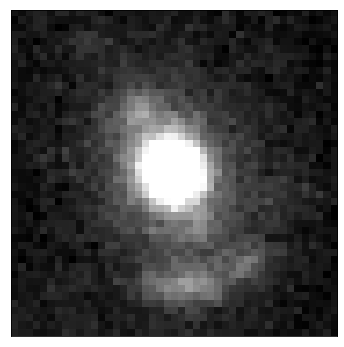

In [93]:
def show_image(image_data):
    
    # plot image
    cmap = mpl.cm.get_cmap("gray").copy()
    cmap.set_bad(color='k', alpha=1.)

    v_min = -5
    v_max = 90

    f, axes = plt.subplots(figsize=(6, 6), sharex=False, sharey=False)

    ax = axes
    
    image = ax.matshow(image_data, origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.autoscale(False)

    plt.show()
    plt.close()

    
show_image(i)

In [98]:
def model(img_data, fwhm, kwargs_lens_initial, kwargs_source_initial, kwargs_lens_light_initial):
    # set models to use
    lens_model_list = ['SIE', 'SHEAR']
    source_model_list = ['SERSIC_ELLIPSE']
    lens_light_model_list = ['SERSIC_ELLIPSE']
    
    #lens_model_class = LensModel(lens_model_list)
    #source_model_class = LightModel(source_model_list)
    #lens_light_model_class = LightModel(lens_light_model_list)    

    # generate the coordinate grid and image properties (we only read out the relevant lines we need)
    _, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)

    # generate the psf variables
    kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}
    
    # more settings for model
    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

    kwargs_data = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC
                # check that units are in arcsec^
               'image_data': img_data}  # 2d data vector
    
    
    # lens models
                   
    fixed_lens = []
    kwargs_lens_init = []
    kwargs_lens_sigma = []
    kwargs_lower_lens = []
    kwargs_upper_lens = []

    fixed_lens.append({})  # for this example, we fix the power-law index of the lens model to be isothermal
    kwargs_lens_init.append(kwargs_lens_initial)
    kwargs_lens_sigma.append({'theta_E': .2, 'e1': 0.05, 'e2': 0.05,
                         'center_x': 0.05, 'center_y': 0.05})
    kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10})
    kwargs_upper_lens.append({'theta_E': 10., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10})

    fixed_lens.append({'ra_0': 0, 'dec_0': 0})
    kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.})
    kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
    kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
    kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

    lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


    fixed_source = []
    kwargs_source_init = []
    kwargs_source_sigma = []
    kwargs_lower_source = []
    kwargs_upper_source = []


    fixed_source.append({})
    kwargs_source_init.append(kwargs_source_initial)
    kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.2, 'center_y': 0.2})
    kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
    kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

    source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


    fixed_lens_light = []
    kwargs_lens_light_init = []
    kwargs_lens_light_sigma = []
    kwargs_lower_lens_light = []
    kwargs_upper_lens_light = []


    fixed_lens_light.append({})
    kwargs_lens_light_init.append(kwargs_lens_light_initial)
    kwargs_lens_light_sigma.append({'n_sersic': 1, 'R_sersic': 0.3, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.1, 'center_y': 0.1})
    kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
    kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

    lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

    kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}
    
    # likelihood fitting process
    kwargs_likelihood = {'source_marg': False}
    kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_model_list, 'lens_light_model_list': lens_light_model_list}

    multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]
    # if you have multiple  bands to be modeled simultaneously, you can append them to the mutli_band_list
    kwargs_data_joint = {'multi_band_list': multi_band_list, 
                         'multi_band_type': 'multi-linear'  # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.
                        }
    kwargs_constraints = {}

    fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

    fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 100}],
                       ['MCMC', {'n_burn': 100, 'n_run': 300, 'walkerRatio': 10, 'sigma_scale': .1}]
            ]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()
    
    # plot the observed, the model, and residuals
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
    f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

    modelPlot.data_plot(ax=axes[0])
    modelPlot.model_plot(ax=axes[1])
    modelPlot.normalized_residual_plot(ax=axes[2], v_min=-6, v_max=6)

    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()
    plt.close()
    
    

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-115442.27389092205 reduced X^2 of best position
-115673158.4387039 logL
2004 effective number of data points
[{'theta_E': 4.365210572621653, 'e1': -0.05124988796377797, 'e2': 0.05005776031427125, 'center_x': -0.016151900887585485, 'center_y': 0.13477423417415457}, {'gamma1': -0.08873970421231975, 'gamma2': 0.05145842486299463, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.11480934566188954, 'n_sersic': 0.5003534463777696, 'e1': -0.06848848763689415, 'e2': 0.1172927510967667, 'center_x': -0.204489841167157, 'center_y': 0.5452393909510477}] source result
[{'amp': 1, 'R_sersic': 0.040073905035643106, 'n_sersic': 4.902060170139546, 'e1': -0.2747576257031376, 'e2': -0.17696610076034686, 'center_x': 0.029028634982549904, 'center_y': -0.11218448742194949}] lens light result
[] point source result
{} special param result
17.210849046707153 time used for  PSO


100%|█████████████████████████████████████████| 400/400 [01:34<00:00,  4.25it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  100
Sampling iterations (in current run): 400
94.483149766922 time taken for MCMC sampling
-114228.0630373497 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  114228.06303734974


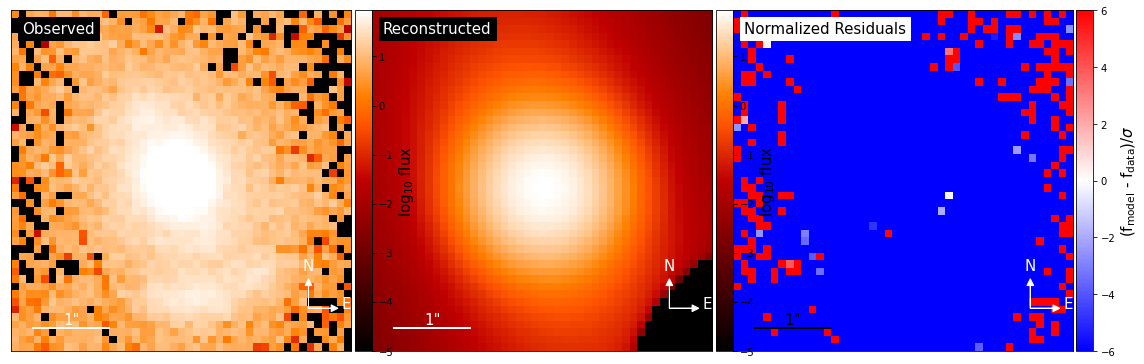

In [99]:
# test model:

kwargs_lens_initial = {'theta_E': 4, 'e1': 0., 'e2': 0.,'center_x': 0., 'center_y': 0.}
kwargs_source_initial = {'R_sersic': 0.3, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0., 'center_y': 0}
kwargs_lens_light_initial = {'R_sersic': 0.1, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': 0., 'center_y': 0}

model(img_data = i, fwhm = fwhm_i, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial, 
      kwargs_source_initial = kwargs_source_initial)